In [8]:
import pandas as pd

# Load the data from the file into a DataFrame
file_path = 'data/20240102140017.txt'
df = pd.read_csv(file_path, sep='\t')  # Assuming the separator is a tab, as common in such data logs

In [9]:
df.head() 

,时间,设备名称,加速度X(g),加速度Y(g),加速度Z(g),角速度X(°/s),角速度Y(°/s),角速度Z(°/s),角度X(°),角度Y(°),...,磁场X(uT),磁场Y(uT),磁场Z(uT),四元数0(),四元数1(),四元数2(),四元数3(),温度(°C),版本号(),电量(%)
0,2024-1-2 14:0:17:967,WT901BLE67(D1376ACA69A3),0.247,-0.080,0.959,-1.038,-0.366,-0.122,-5.96,-13.14,...,-24.208,17.15,-74.058,0.73230,-0.11243,-0.05081,-0.66962,21.3,10080.1.7,100
1,2024-1-2 14:0:17:967,WT901BLE67(D1376ACA69A3),0.247,-0.092,0.951,0.427,1.038,1.648,-5.99,-13.12,...,-24.208,17.15,-74.058,0.73230,-0.11243,-0.05081,-0.66962,21.3,10080.1.7,100
2,2024-1-2 14:0:18:89,WT901BLE67(D1376ACA69A3),0.240,-0.092,0.951,0.427,1.038,1.648,-5.99,-13.12,...,-24.208,17.15,-74.058,0.73267,-0.11478,-0.05029,-0.66888,21.3,10080.1.7,100
3,2024-1-2 14:0:18:89,WT901BLE67(D1376ACA69A3),0.240,-0.089,0.957,0.000,0.549,1.160,-6.00,-13.04,...,-24.208,17.15,-74.058,0.73267,-0.11478,-0.05029,-0.66888,21.3,10080.1.7,100
4,2024-1-2 14:0:18:154,WT901BLE67(D1376ACA69A3),0.233,-0.089,0.957,0.000,0.549,1.160,-6.00,-13.04,...,-24.208,17.15,-74.058,0.73267,-0.11478,-0.05029,-0.66888,21.3,10080.1.7,100


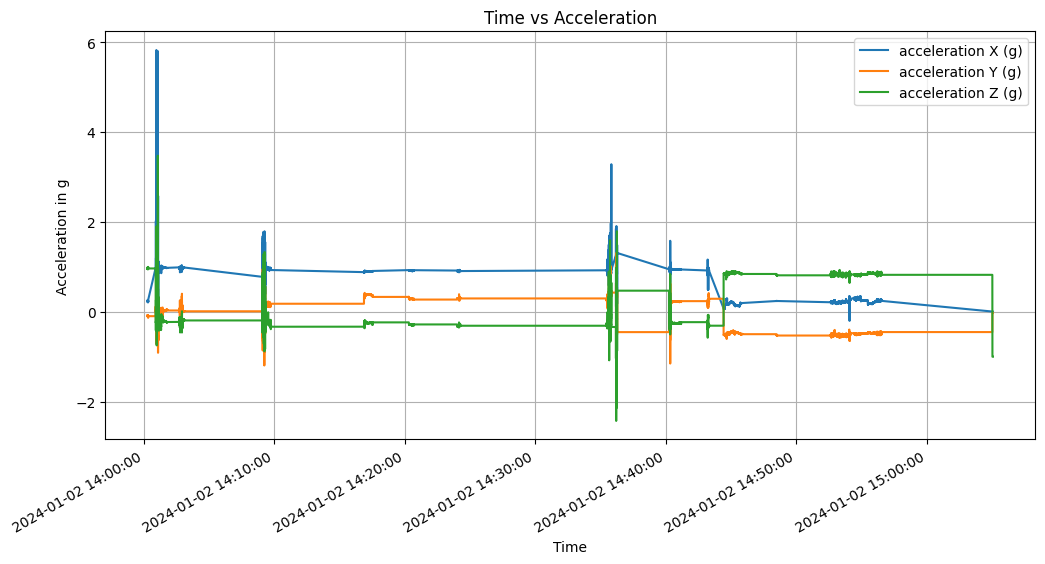

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Adjusting the datetime parsing to accommodate the specific format of the timestamps
# The format seems to be 'year-month-day hour:minute:second:millisecond'
df['时间'] = pd.to_datetime(df['时间'], format='%Y-%m-%d %H:%M:%S:%f')

# Re-plotting
plt.figure(figsize=(12, 6))

# Plotting each acceleration component
plt.plot(df['时间'], df['加速度X(g)'], label='acceleration X (g)')
plt.plot(df['时间'], df['加速度Y(g)'], label='acceleration Y (g)')
plt.plot(df['时间'], df['加速度Z(g)'], label='acceleration Z (g)')

# Formatting the plot
plt.xlabel('Time')
plt.ylabel('Acceleration in g')
plt.title('Time vs Acceleration')
plt.legend()
plt.grid(True)

# Improve date formatting on x-axis
plt.gcf().autofmt_xdate() # Auto format for better date representation
myFmt = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
plt.gca().xaxis.set_major_formatter(myFmt)

# Show the plot
plt.show()

